In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "../..")

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HarshithBachimanchi/PlanktonReview/blob/main/notebooks/03.track_3D_holography.ipynb)

In [2]:
# Commands for colab ´

# !pip install deeptrack
# !git clone https://github.com/HarshithBachimanchi/PlanktonReview.git
# %cd PlanktonReview/notebooks

In [3]:
import random

import deeptrack as dt
import deeptrack.extras
import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io

/opt/anaconda3/envs/tf-metal/lib/python3.8/site-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/opt/anaconda3/envs/tf-metal/lib/python3.8/site-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import analysis as an

In [5]:
# # Load the data
# frames = np.load("/Users/harshithbachimanchi/Documents/Courses/ScientificWriting/holography_videos/Frames_ps_600.npy")
# positions = np.load("/Users/harshithbachimanchi/Documents/Courses/ScientificWriting/holography_videos/detections_220419_ps7.npy", allow_pickle=True)
# frames = frames[2:]
# positions = positions[2:]
# print(np.shape(frames), np.shape(positions))

In [6]:
# Load the data
frame = np.load("../data/frame_ps.npy")
positions = np.load("../data/positions_ps.npy")

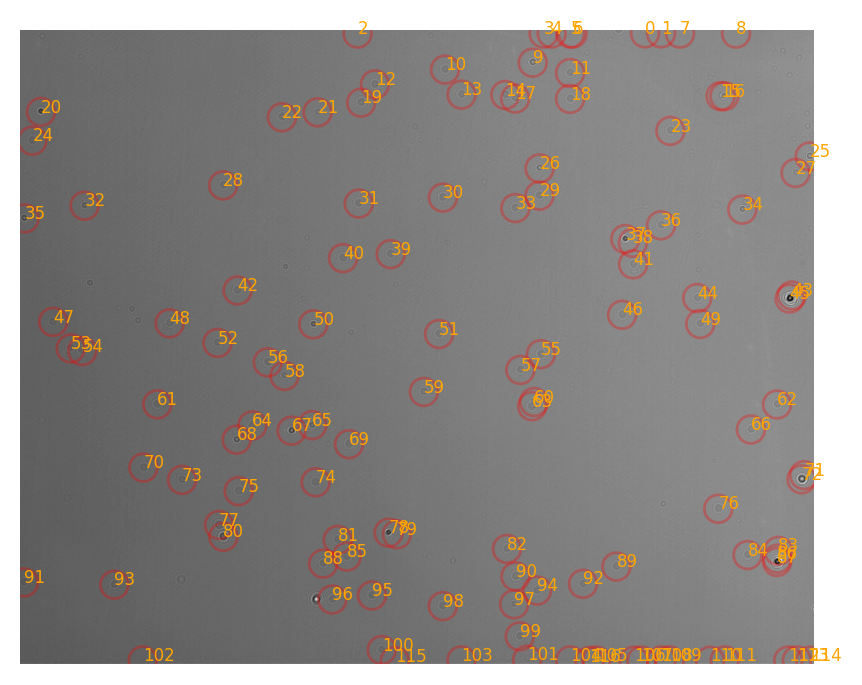

In [7]:
# frame = frames[0]
dpi=200
plt.figure(figsize=(frame.shape[0]/dpi, frame.shape[1]/dpi), dpi=dpi, frameon=False)
plt.imshow(frame, cmap="gray")
plt.scatter(positions[:, 0], positions[:, 1], s=100, facecolors="None", edgecolors="red", alpha=0.3)
[plt.text(positions[:,0][i], positions[:, 1][i], str(i), color="orange", fontsize=6) for i in range(len(positions))]
plt.axis("off")
plt.show()

In [8]:
plankton_numbers = [61, 59, 46]

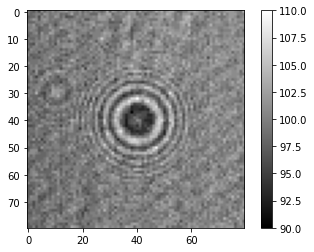

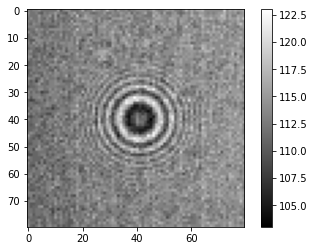

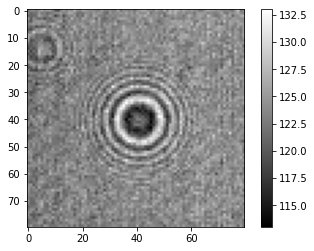

In [10]:
crop_width = 80
crops=[]
for plankton in plankton_numbers:
    pos = positions[:,0][plankton], positions[:,1][plankton]
    crop = frame[int(pos[1] - crop_width/2) :int(pos[1] + crop_width/2), int(pos[0] - crop_width/2) : int(pos[0] + crop_width/2)]
    crops.append(crop)
    plt.imshow(crop, cmap="gray")
    plt.colorbar()
    plt.show()
# crops = np.expand_dims(crops, axis=-1)

In [11]:
import scipy.fft as sp
import math
def reconstruction(z):
    def inner(image):
        wavelength = 0.625  # wavelength
        pi = math.pi
        k = 2 * pi * (1.33) / wavelength
        dx = 5.2  # Pixelsize of the camera
        # -------------------------------
        N1 = np.size(image, 0)
        N2 = np.size(image, 1)
        ky = 2 * pi / dx * (np.arange(-N1 / 2, (N1 / 2)) / N1)
        kx = 2 * pi / dx * (np.arange(-N2 / 2, (N2 / 2)) / N2)
        [KX, KY] = np.meshgrid(kx, ky)
        kz = np.sqrt(k ** 2 - (np.square(KX) + np.square(KY)))  # Planewave
        kz[kz.imag != 0] = 0
        T = np.exp(1j * kz * z)
        ImageFFT = sp.fftshift(sp.fft2(sp.fftshift(image)))
        ReconstructedImageFFT = np.multiply(ImageFFT, T)
        ReconstructedImageFFT = ReconstructedImageFFT * (np.any(np.sqrt(np.square(KX) + np.square(KY)) > k) == 0)
        ReconstructedImage = abs(sp.fftshift(sp.ifft2(sp.fftshift(ReconstructedImageFFT))))
        return ReconstructedImage
    return inner

In [12]:
Reconstruction = dt.Lambda(reconstruction, z=-500)
test = dt.Value(lambda: random.choice(crops)) >> Reconstruction

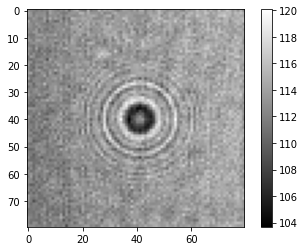

In [18]:
plt.imshow(test.update().resolve(), cmap="gray")
plt.colorbar()

In [33]:
args = dt.Arguments(
    translate=lambda: np.random.randn(2) * 1,
    rotate=lambda:np.random.uniform(0, np.pi*2),
    z=lambda: np.random.randint(0, 3000),
)

group = (
    dt.Lambda(reconstruction, z=args.z)
    >> dt.Affine(translate=args.translate)
    >> dt.Affine(rotate=args.rotate)
)[..., np.newaxis]

equivariance = (
    dt.models.lodestar.TranslationalEquivariance(args.translate)
    >> dt.models.lodestar.Rotational2DEquivariance(args.rotate)
    >> dt.models.lodestar.Equivariance(1, args.z / 1000, indexes=2)
)


In [34]:
import random
# training_set = dt.Value(dt.Value(lambda: random.choice(crops)))#[..., 0]
training_set = dt.Value(crops[1])

(80, 80, 1)
106


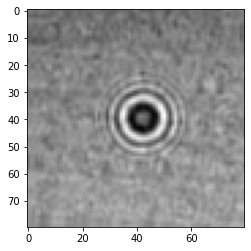

In [44]:
x = (training_set >> group).update()()
print(x.shape)
print(x.get_property("z"))
plt.imshow(x, cmap="gray")
plt.show()

In [45]:
generator = dt.models.lodestar.LodeSTARGenerator(
    training_set,
    3, 
    (group, equivariance), 
    batch_size=8, 
    min_data_size=200, 
    max_data_size=400
)

In [46]:
with generator:
    model = dt.models.LodeSTAR(input_shape=(None, None, 1), num_outputs=3)
    model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())
    model.fit(generator, epochs=100, steps_per_epoch=100)

Generating 207 / 200 samples before starting training
Metal device set to: AMD Radeon Pro 5300M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB



2022-07-29 14:02:39.897266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-29 14:02:39.903163: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-29 14:02:39.904824: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2022-07-29 14:02:42.357622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 7s 39ms/step - total_loss: 3.8666 - consistency_loss: 3.0333
Epoch 2/100
100/100 [==============================] - 4s 40ms/step - total_loss: 3.5680 - consistency_loss: 2.6288
Epoch 3/100
100/100 [==============================] - 4s 39ms/step - total_loss: 3.1287 - consistency_loss: 2.2961
Epoch 4/100
100/100 [==============================] - 4s 41ms/step - total_loss: 2.7554 - consistency_loss: 2.0023
Epoch 5/100
100/100 [==============================] - 4s 42ms/step - total_loss: 3.2682 - consistency_loss: 2.2283
Epoch 6/100
100/100 [==============================] - 4s 44ms/step - total_loss: 4.3369 - consistency_loss: 2.7872
Epoch 7/100
100/100 [==============================] - 4s 44ms/step - total_loss: 3.7739 - consistency_loss: 2.3540
Epoch 8/100
100/100 [==============================] - 4s 44ms/step - total_loss: 3.1364 - consistency_loss: 2.1417
Epoch 9/100
100/100 [==============================] - 5s 45ms/step - total_loss: 2.

In [48]:
# plt.plot(history.history["consistency_loss"], label="consistency_loss")
# plt.plot(history.history["total_loss"], label="total_loss")
# plt.label()
# plt.show()

In [50]:
model.model.model.save_weights("../models/ps-lodestar-3D-220729.h5")

### Testing
Smaller crop

1/1 [==============================] - 0s 41ms/step


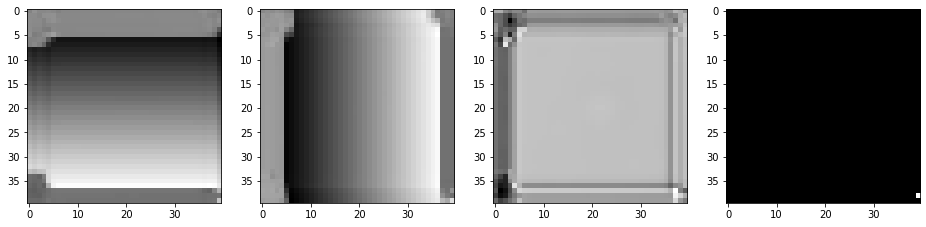

In [112]:
test_crop = crop[np.newaxis, ..., np.newaxis]
p, w = model.predict(test_crop)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
ax1.imshow(p[0, ..., 0], cmap="gray")
ax2.imshow(p[0, ..., 1], cmap="gray")
ax3.imshow(p[0, ..., 2], cmap="gray")
ax4.imshow(w[0, ..., 0], cmap="gray")

In [113]:
pos = (p * w).sum(axis=(0, 1, 2)) / w.sum(axis=(0, 1, 2))  
pos

array([35.066547, 35.91519 , -4.705547], dtype=float32)

### Testing
full frame

1/1 [==============================] - 0s 167ms/step


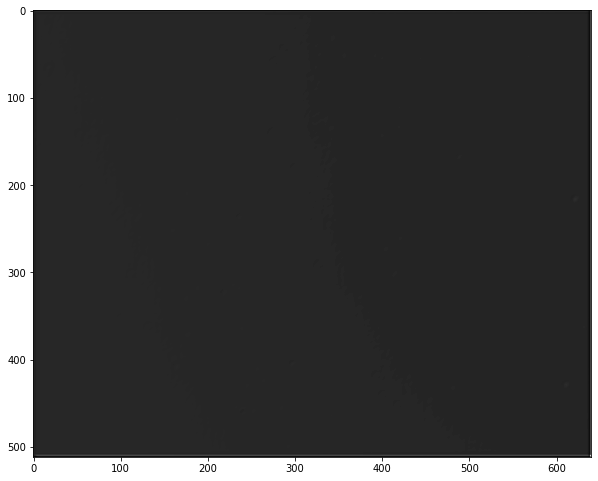

In [195]:
#frame2 = (frame - np.min(frame)) / (np.max(frame) - np.min(frame))

test_frame = frame2[np.newaxis, ..., np.newaxis]
p, w = model.predict(test_frame)

plt.figure(figsize=(10, 10 ))
plt.imshow(w[0, ..., 0], cmap="gray")

In [196]:
pos = (p * w).sum(axis=(0, 1, 2)) / w.sum(axis=(0, 1, 2))  
pos

array([ 5.1052878e+02,  6.3417902e+02, -2.8520089e-01], dtype=float32)

In [197]:
alpha = 1
cutoff = 0.0007
dets = model.predict_and_detect(test_frame, alpha=alpha, beta=alpha-1, cutoff=cutoff, mode="constant")

1/1 [==============================] - 0s 148ms/step


(-0.5, 1279.5, 1023.5, -0.5)

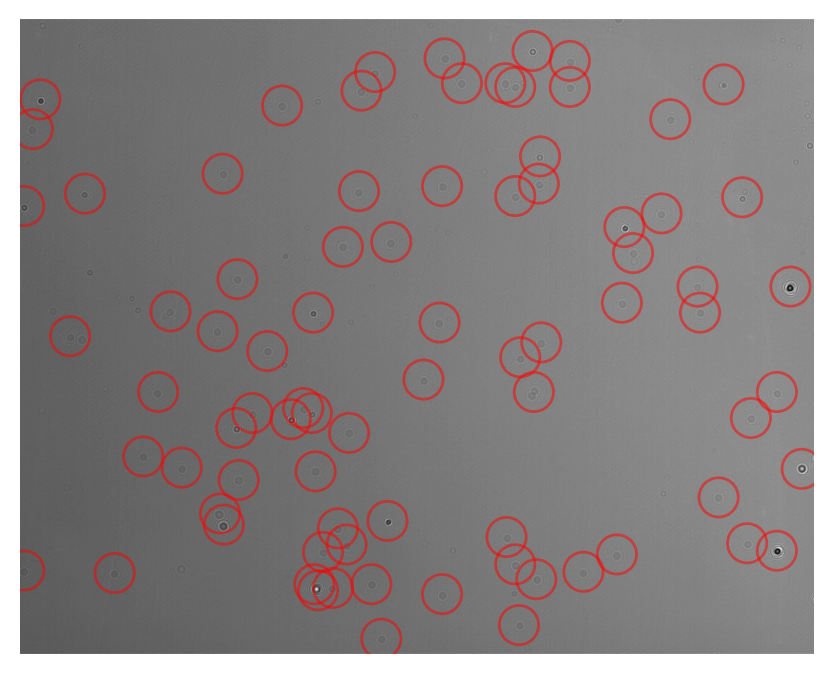

In [198]:
dpi=200
plt.figure(figsize=(frame.shape[0]/dpi, frame.shape[1]/dpi), dpi=dpi, frameon=False)
plt.scatter(dets[0][:, 1], dets[0][:, 0], s=200, facecolor="none", linewidths=1, edgecolors="r", alpha=0.5)
plt.imshow(frame, cmap="gray")
plt.axis("off")

In [199]:
dets

[array([[ 5.08747215e+01,  8.26277222e+02, -2.88416952e-01],
        [ 6.28763237e+01,  6.84271912e+02, -2.86864817e-01],
        [ 6.68725739e+01,  8.86276062e+02, -2.88479298e-01],
        [ 8.48727112e+01,  5.72269409e+02, -2.86090463e-01],
        [ 1.02875565e+02,  7.12273499e+02, -2.87082434e-01],
        [ 1.02874779e+02,  7.82275024e+02, -2.87752777e-01],
        [ 1.04880470e+02,  1.13427771e+03, -2.88095623e-01],
        [ 1.08876320e+02,  7.98276367e+02, -2.88044006e-01],
        [ 1.08873497e+02,  8.86276001e+02, -2.88343877e-01],
        [ 1.14873245e+02,  5.50268982e+02, -2.85972148e-01],
        [ 1.28878235e+02,  3.22499161e+01, -2.77408391e-01],
        [ 1.38874512e+02,  4.22266449e+02, -2.85017520e-01],
        [ 1.60874329e+02,  1.04827795e+03, -2.88905233e-01],
        [ 1.76874527e+02,  2.02595387e+01, -2.82609910e-01],
        [ 2.20872803e+02,  8.38276855e+02, -2.88476557e-01],
        [ 2.48874252e+02,  3.26263794e+02, -2.84306437e-01],
        [ 2.64872650e+02

Single particle trace

In [200]:
windows = np.load("/Users/harshithbachimanchi/Desktop/GoogleDrive/3DTracking-Project/polystyrene-monochrome-camera/windows_sliced_particle_39.npy")
z_std = np.load("/Users/harshithbachimanchi/Desktop/GoogleDrive/3DTracking-Project/polystyrene-monochrome-camera/z_dist_sliced_particle_39.npy")

In [201]:
reshaped_windows = windows[..., np.newaxis]
p, w = model.predict(reshaped_windows)

12/12 [==============================] - 0s 22ms/step


In [204]:
pos = model.predict_and_detect(reshaped_windows)#, alpha=alpha, beta=alpha-1, cutoff=cutoff, mode="constant")

12/12 [==============================] - 0s 23ms/step


In [205]:
pos

[array([[32.03697  , 33.280243 , -3.9606524]], dtype=float32),
 array([[29.990072, 33.277065, -3.947001]], dtype=float32),
 array([[30.008984, 33.278355, -3.954192]], dtype=float32),
 array([[29.97614  , 33.26962  , -3.9541245]], dtype=float32),
 array([[30.002304, 33.279926, -3.95093 ]], dtype=float32),
 array([[29.99164  , 33.27249  , -3.9523752]], dtype=float32),
 array([[29.987488 , 33.273155 , -3.9602034]], dtype=float32),
 array([[29.976715 , 33.274773 , -3.9666548]], dtype=float32),
 array([[29.987322 , 33.27215  , -3.9707322]], dtype=float32),
 array([[29.98901  , 33.276085 , -3.9740987]], dtype=float32),
 array([[29.988842 , 33.277336 , -3.9750051]], dtype=float32),
 array([[29.971498, 33.269863, -3.984281]], dtype=float32),
 array([[29.972666, 33.272064, -3.976666]], dtype=float32),
 array([[29.96843  , 33.272243 , -3.9823031]], dtype=float32),
 array([[29.97629  , 33.27061  , -3.9812884]], dtype=float32),
 array([[32.042114 , 33.28121  , -3.9867878]], dtype=float32),
 array(

In [214]:
pos = (p * w).sum(axis=(1, 2)) / w.sum(axis=(1, 2))  
pos

array([[22.254095 , 23.177774 , -4.3335276],
       [22.189953 , 23.110664 , -4.340142 ],
       [22.269499 , 23.19527  , -4.3328786],
       ...,
       [22.913088 , 23.853636 , -4.2556205],
       [22.866213 , 23.807043 , -4.261955 ],
       [22.87799  , 23.816267 , -4.258265 ]], dtype=float32)

In [206]:
pos = np.array(pos)

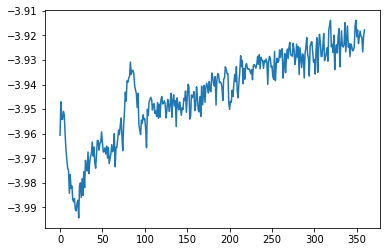

In [213]:
plt.plot(pos[:,0][:,2])

In [13]:

traces = []
for idx in range(len(dets)):

    connections = []
    connected_observations = []
    # Trace doroplets
    for idy, trace in enumerate(traces):

        last_frame, *pos = trace[-1]
        if idx - last_frame > 4:
            continue

        for idz, new_pos in enumerate(dets[idx]):
            distance = np.sqrt(np.square(new_pos[:2] - pos[:2]).sum())
            
            if (
                distance < 10 and idz not in connected_observations
            ):
                connected_observations.append(idz)
                trace.append(np.array((idx, *new_pos)))

    detections = [p for i, p in enumerate(dets[idx]) if i not in connected_observations]

    # Initiate new traces
    for det in detections:
        traces.append([np.array((idx, *det))])

# traces = list(filter(lambda t: len(t) > , traces))

len(traces)

611

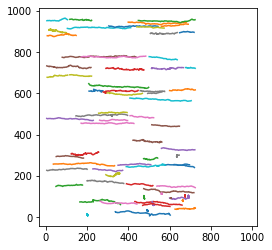

In [14]:
_traces = list(map(np.array, traces))
_traces = list(filter(lambda t: len(t) > 20, _traces))
for trace in _traces:
    plt.plot(trace[:, 2], trace[:, 1])
plt.axis("square")
plt.show()


<ipython-input-1-19f2b18317f8>:14: UserWarning: linewidths is ignored by contourf
  f = ax.contourf(X, Y, val, 100, offset=0.02, linewidths=0, vmin=-0.05, vmax=0.1)


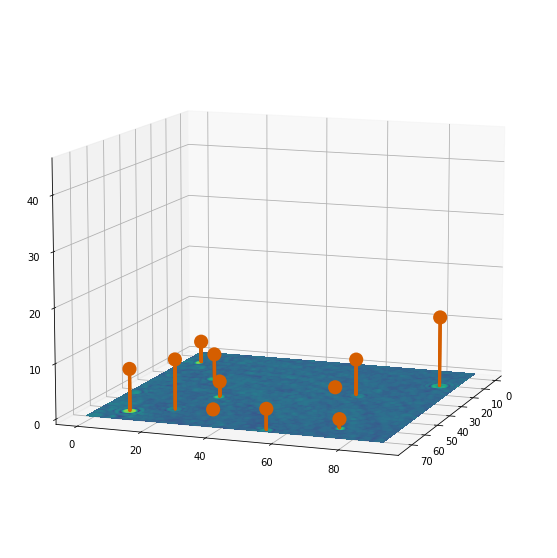

In [15]:
import seaborn
t = 30
val = dt.AveragePooling((1,1))(xvout[t, :400, 400:800, 1])
val = dt.GaussianBlur(2)(val)
# plt.set_cmap("bone")
val = np.array(val)

X, Y = np.meshgrid(np.arange(val.shape[1]) * 2 *0.114, np.arange(val.shape[0])* 2 *0.114)

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection="3d")

f = ax.contourf(X, Y, val, 100, offset=0.02, linewidths=0, vmin=-0.05, vmax=0.1)

for c in f.collections:
    c.set_edgecolor("none")

detections = np.array(detections)
_dets = dets[0][dets[0][:, 0] < 400]
for _dets in _traces:
    _dets = _dets[_dets[:, 0] < t]
    _dets = _dets[:, 1:]
    if not _dets.size or _dets[-1, 1] < 400 or _dets[-1, 1] > 800 or _dets[-1, 0] > 400:
        continue
    _dets[:, 0] = _dets[:, 0] * 2 * 0.114
    _dets[:, 1] = (_dets[:, 1] - 400) * 2 * 0.114
    _dets[:, 2] = _dets[:, 2] + 0
    
    d = _dets[-1]

    ax.scatter(_dets[-1, 1], _dets[-1, 0], np.abs(_dets[-1, 2]), alpha=1, s=200, edgecolors="none", facecolors=seaborn.color_palette("colorblind")[3])
    ax.scatter([d[1]]*100, [d[0]] * 100, np.linspace(np.abs(d[2]), 0.05, 100), color=seaborn.color_palette("colorblind")[3], marker=".", alpha=1)


ax.view_init(11, 20)
# plt.xticks([])
# plt.yticks([])
ax.set_zlim(0, 200* 2 *0.114)
plt.savefig("vertical_prediction.png", dpi=200, bbox_inches="tight")

In [16]:
completed_traces = holotraces["CompletedTraces"]

all_holo_traces = []

for i in range(completed_traces.shape[1]):

    trace = completed_traces[0, i]
    trace = np.array(trace[0][0][1])
    trace[:, 0] -= 203
    trace[:, 1:3] = trace[:, 1:3] / 0.114 / 2 + 2
    all_holo_traces.append(trace)

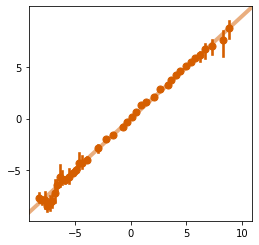

In [17]:
import scipy.spatial

z_pred = []
z_holo = []
for t in range(102):
    positions = []
    holo_pos = []
    for trace in _traces:
        x = trace[trace[:, 0] == t]
        if x.size:
            positions.append(x[0])

    for trace in all_holo_traces[:]:
        x = trace[trace[:, 0] == t]
        if x.size:
            holo_pos.append(x[0])

    positions = np.array(positions)
    holo_pos = np.array(holo_pos)
    dist = scipy.spatial.distance.cdist(positions[:, 1:3], holo_pos[:, 1:3])

    row, col = scipy.optimize.linear_sum_assignment(dist)


    costs = dist[row, col]
    mrow = row[costs < 5]
    mcol = col[costs < 5]


    for r, c in zip(mrow, mcol):
        z_pred.append(positions[r, 3])
        z_holo.append(holo_pos[c, 3])

z_pred_arr = np.array(z_pred)
z_holo_arr = np.array(z_holo)

z_pred_arr += np.mean(z_holo_arr) - np.mean(z_pred_arr)

plt.figure(figsize=(4, 4))
plt.gca().set_aspect(1 / plt.gca().get_data_ratio())
seaborn.regplot(x=z_holo_arr - 10, y=z_pred_arr - 10, ci=99, x_bins=40, truncate=False, color=seaborn.color_palette("colorblind")[3], x_ci=99, fit_reg=False)
plt.gca().set_aspect(1 / plt.gca().get_data_ratio())
plt.yticks([-5, 0, 5])
plt.axline((5, 5), (10, 10), c=seaborn.color_palette("colorblind")[3], alpha=.5, linewidth=4)
plt.savefig("z_truevsactual.svg")

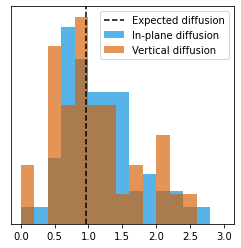

In [18]:
delta_time = all_holo_traces[0][1, 6] - all_holo_traces[0][0, 6]

def get_msd(x, max_dt=4):

    output = []
    for delt in range(max_dt):
        delta = x[1 + delt :] - x[: -(1 + delt)]
        
        th = 100 * np.sqrt(delt + 1)
        if np.any(delta > th):
            print(np.sum(delta > th))

        delta[delta > th] = 0
        squared_displacement = np.square(delta).sum(axis=-1)

        output.append(
            (
                np.mean(squared_displacement),
                np.std(squared_displacement),
                len(squared_displacement),
            )
        )

    return np.array(output)

def fit_to_line(msd):
    return np.polyfit(range(1, msd.shape[0]+1), msd[:, 0], 1)

msds = []
msds_z = []
for positions in _traces:
    positions = np.array(positions)
    positions[:, 2] -= np.arange(positions.shape[0]) * (positions[-1, 2] - positions[0, 2]) / positions.shape[0]
    
    msd = get_msd(positions[:, 1:3] * 0.114 * 2, 10) / 2
    a, b = fit_to_line(msd[:4])
    msds.append(a)

    msd = get_msd(positions[:, 3:4] * 1.5/1.33, 10)
    a, b = fit_to_line(msd[:4])
    msds_z.append(a)


plt.figure(figsize=(4, 4))
plt.hist(np.array(msds) / delta_time / 2, 15, range=(0, 3), density=True, alpha=1, facecolor=seaborn.color_palette("colorblind")[9])
plt.hist(np.array(msds_z) / delta_time / 2, 15, range=(0, 3), density=True, alpha=0.66, facecolor=seaborn.color_palette("colorblind")[3])

plt.yticks([])
plt.axvline(0.9638, c="k", linestyle="--")
plt.legend(["Expected diffusion", "In-plane diffusion", "Vertical diffusion", ])
plt.savefig("diffusion_histogram.svg")
